# Imports

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Functions

In [5]:
def det_feat(img):
    #function for detecting SIFT features
    
    sift = cv2.xfeatures2d.SIFT_create()
    points, descriptors = sift.detectAndCompute(img, None)
    
    return points, descriptors

def match(img1, img2):
    #function for matching two images
    
    #get features for each image
    p1, d1 = det_feat(img1)
    p2, d2 = det_feat(img2)
    
    #find nearest neighbours for each image
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(d1, d2, k=2)
    
    #find good neighbours to be considered as matches
    top = []
    matching_inds = []
    for a, b in matches:
        if a.distance < 0.75*b.distance:
            top.append([a])
            matching_inds.append((a.queryIdx, a.trainIdx))
    
    return p1, d1, p2, d2, np.array(matching_inds), top

def find_homo_mat(pts1, pts2):
    #function for finding the homography matrix
    
    maxx = 0
    bestH = []
    
    #run RANSAC for 100 iterations
    for i in range(100):
        
        #selecting random samples
        inds = np.random.choice(pts1.shape[0], 4)
        
        #defining the matrix
        M = []
        for j in inds:
            x1 = pts1[j][0]
            y1 = pts1[j][1]
            x2 = pts2[j][0]
            y2 = pts2[j][1]
            M.append([
                -x2, -y2, -1, 0, 0, 0, x1*x2, x1*y2, x1
            ])
            M.append([
                0, 0, 0, -x2, -y2, -1, y1*x2, y1*y2, y1
            ])
        M = np.array(M)
        
        #solving the equation using svd
        u, s, v = np.linalg.svd(M)
        h = v[-1, :]
        H = np.reshape(h, (3, 3))
        
        pts2aug = np.hstack((pts2, np.ones((pts2.shape[0], 1))))
        proj = np.matmul(H, pts2aug.T)
        proj = (proj / proj[2, :])[:2, :]
        err = np.sqrt(np.sum(np.power(pts1 - proj.T, 2), axis=1))
        thresh = 15
        err[err > thresh] = 0
        err[err != 0] = 1;
        correct = np.sum(err)
        if(correct > maxx):
            maxx = correct
            bestH = H
        
    return bestH

def get_matching_coords(p1, p2, matching_inds):
    pts1, pts2 = [], []
    for i in range(matching_inds.shape[0]):
        pts1.append(p1[matching_inds[i, 0]].pt)
        pts2.append(p2[matching_inds[i, 1]].pt)
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    
    return pts1, pts2


def trim(res):
    
    res = res[~np.all(res == 0, axis=(1, 2))]
    res = res[:, ~np.all(res == 0, axis=(0, 2))]

    return res

def stitch(img1, img2, H, order=False):
    
    #bring img2 to img1's plane
    if order:
        res = cv2.warpPerspective(img2, H, (img1.shape[1]+img2.shape[1], img1.shape[0]+img2.shape[0]))
    else:
        res = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))
    
    #find locations where both images are not present
    img1_mask = img1 != 0
    res_mask = res[0:img1.shape[0], 0:img1.shape[1], :] != 0
    mask = np.logical_not(img1_mask * res_mask)
    
    #join the images
    res[0:img1.shape[0], 0:img1.shape[1], :] += img1*mask
    
    #remove all 0 rows and cols
    res = trim(res)
            
    return res

def stitch_multiple_inorder(paths): 
    
    img1 = cv2.imread(paths[0])
    for p in paths[1:]:
        img2 = cv2.imread(p)

        #finding matchings
        p1, d1, p2, d2, matching_inds, _ = match(img1, img2)

        #extract the coordinates of the matching points
        matching_inds = np.array(matching_inds)
        pts1, pts2 = [], []
        for i in range(matching_inds.shape[0]):
            pts1.append(p1[matching_inds[i, 0]].pt)
            pts2.append(p2[matching_inds[i, 1]].pt)
        pts1 = np.array(pts1)
        pts2 = np.array(pts2)

        #finding homography matrix
        H = find_homo_mat(pts1, pts2)

        #stitching
        img1 = stitch(img1, img2, H, True)
        
    return img1

def stitch_multiple_unordered(paths):
    imgs = []
    for p in paths:
        imgs.append(cv2.imread(p))
    for i in range(len(imgs)):
        imgs[i] = np.pad(imgs[i], ((imgs[i].shape[0], imgs[i].shape[0]), (imgs[i].shape[1], imgs[i].shape[1]), (0, 0)), 'constant')
      
    #find base picture
    maxx = 0
    for i in range(len(imgs)):
        cnt = 0
        for j in range(len(imgs)):
            if j == i:
                continue
            _, _, _, _, cmatching_inds, _ = match(imgs[i], imgs[j])
            cnt += cmatching_inds.shape[0]
        if cnt > maxx:
            maxx = cnt
            ind = i
         
    while len(imgs) != 1:
            
        maxx = 0
        for i in range(len(imgs)):
            if i == ind:
                continue
            cp1, cd1, cp2, cd2, cmatching_inds, _ = match(imgs[ind], imgs[i])
            if cmatching_inds.shape[0] > maxx:
                maxx = cmatching_inds.shape[0]
                ind_other = i
                p1, d1, p2, d2, matching_inds = cp1, cd1, cp2, cd2, cmatching_inds

        img1 = imgs[ind]
        img2 = imgs[ind_other]
        if(ind > ind_other):
            del(imgs[ind])
            del(imgs[ind_other])
        else:
            del(imgs[ind_other])
            del(imgs[ind])
        
        #extract the coordinates of the matching points
        matching_inds = np.array(matching_inds)
        pts1, pts2 = [], []
        for i in range(matching_inds.shape[0]):
            pts1.append(p1[matching_inds[i, 0]].pt)
            pts2.append(p2[matching_inds[i, 1]].pt)
        pts1 = np.array(pts1)
        pts2 = np.array(pts2)

        #finding homography matrix
        H = find_homo_mat(pts1, pts2)

        #stitching
        img1 = stitch(img1, img2, H)
        
        img1 = np.pad(img1, ((img1.shape[0], img1.shape[0]), (img1.shape[1], img1.shape[1]), (0, 0)), 'constant')

        imgs.append(img1)
        ind = len(imgs) - 1
    
    return trim(imgs[0])

# 1. Matching two images

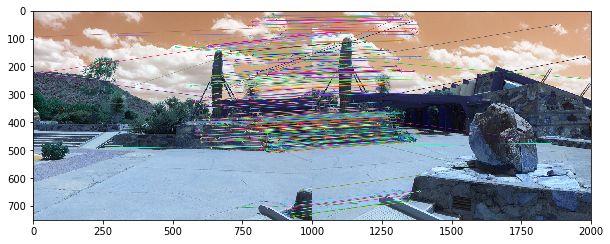

In [6]:
#enter the paths of the images to match
paths = ['../images/image_mosaicing/img3_1.png', '../images/image_mosaicing/img3_2.png']
img1 = cv2.imread(paths[0]) 
img2 = cv2.imread(paths[1])
p1, d1, p2, d2, matching_inds, top = match(img1, img2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.drawMatchesKnn(img1, p1, img2, p2, top, None, flags=2))
plt.show()

# 2 and 3. Estimating Homography and Transformation

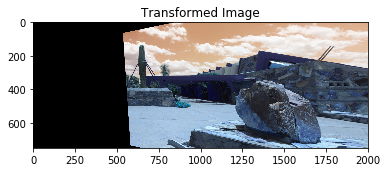

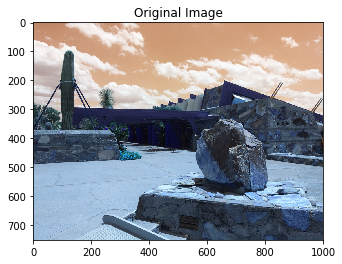

In [7]:
#extract the coordinates of the matching points
pts1, pts2 = get_matching_coords(p1, p2, matching_inds)

#finding homography matrix
H = find_homo_mat(pts1, pts2)

#projecting the second image to the first's frame
res = cv2.warpPerspective(img2, H, (img1.shape[1]+img2.shape[1], img1.shape[0]))

plt.imshow(res)
plt.title("Transformed Image")
plt.show()
plt.imshow(img2)
plt.title("Original Image")
plt.show()

# 4. Image Stitching

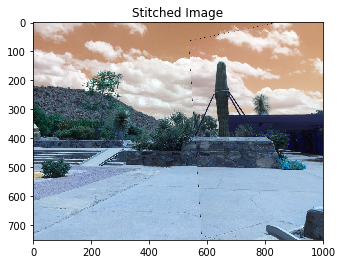

In [8]:
res = stitch(img1, img2, H)

plt.imshow(res)
plt.title("Stitched Image")
plt.show()

# 5. For multiple images

## For images in order (adjacent images have something in common)

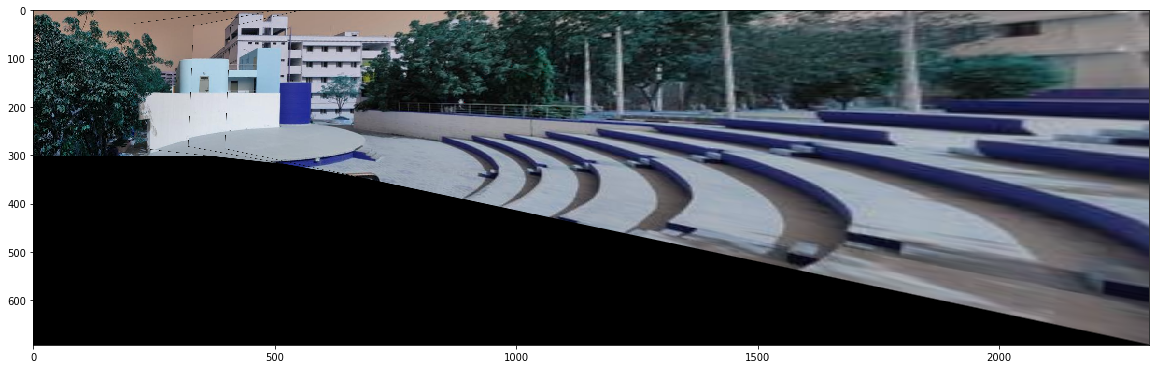

In [9]:
# paths = ['../images/image_mosaicing/img2_1.png', '../images/image_mosaicing/img2_2.png', 
#         '../images/image_mosaicing/img2_3.png', '../images/image_mosaicing/img2_4.png', 
#         '../images/image_mosaicing/img2_5.png', '../images/image_mosaicing/img2_6.png']
# paths = ['../images/image_mosaicing/img5_1.jpg', '../images/image_mosaicing/img5_2.jpg', 
#         '../images/image_mosaicing/img5_3.jpg', '../images/image_mosaicing/img5_4.jpg',]
paths = ['../images/image_mosaicing/img1_1.jpg', '../images/image_mosaicing/img1_2.jpg', 
        '../images/image_mosaicing/img1_3.jpg', '../images/image_mosaicing/img1_4.jpg']
# paths = ['../images/self/1.jpg', '../images/self/2.jpg', 
#         '../images/self/3.jpg', '../images/self/4.jpg']
res = stitch_multiple_inorder(paths)
plt.figure(figsize=(20, 10))
plt.imshow(res)
plt.show()

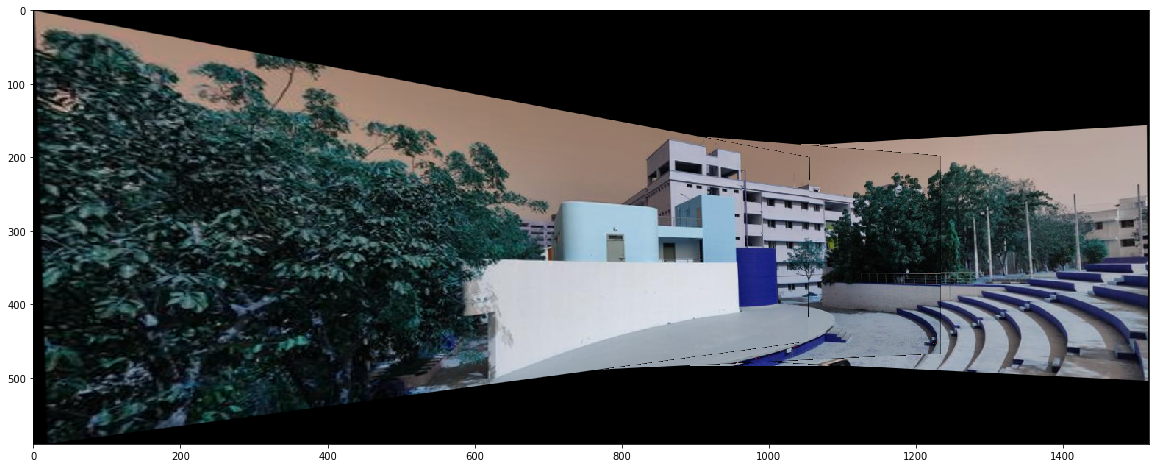

In [10]:
# paths = ['../images/image_mosaicing/img2_1.png', '../images/image_mosaicing/img2_2.png', 
#         '../images/image_mosaicing/img2_3.png', '../images/image_mosaicing/img2_4.png', 
#         '../images/image_mosaicing/img2_5.png', '../images/image_mosaicing/img2_6.png']
# paths = ['../images/image_mosaicing/img5_1.jpg', '../images/image_mosaicing/img5_2.jpg', 
#         '../images/image_mosaicing/img5_3.jpg', '../images/image_mosaicing/img5_4.jpg',]
paths = ['../images/image_mosaicing/img1_1.jpg', '../images/image_mosaicing/img1_2.jpg', 
        '../images/image_mosaicing/img1_3.jpg', '../images/image_mosaicing/img1_4.jpg']
# paths = ['../images/self/1.jpg', '../images/self/2.jpg', 
#         '../images/self/3.jpg', '../images/self/4.jpg']
random.shuffle(paths)
res = stitch_multiple_unordered(paths)
plt.figure(figsize=(20, 10))
plt.imshow(res)
plt.show()